In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("=" * 70)
print("🤖 MACHINE LEARNING MODEL TRAINING")
print("=" * 70)
print("✅ Libraries imported successfully!")

🤖 MACHINE LEARNING MODEL TRAINING
✅ Libraries imported successfully!


In [2]:
# Cell 2: Load Processed Data
df = pd.read_csv('../data/processed/features_engineered.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"📊 Dataset Shape: {df.shape}")
print(f"📅 Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"🎯 Target Variable: sales")
print(f"📈 Total Features: {df.shape[1]}")

# Display basic info
df.head()

📊 Dataset Shape: (175500, 53)
📅 Date Range: 2023-01-29 00:00:00 to 2024-12-30 00:00:00
🎯 Target Variable: sales
📈 Total Features: 53


,date,year,month,day,day_of_week,day_name,is_weekend,is_holiday,store_id,store_type,...,month_cos,dow_sin,dow_cos,price_discount_pct,price_vs_category_avg,weekend_promo,holiday_promo,category_encoded,store_type_encoded,store_size_encoded
0,2023-01-29,2023,1,29,6,Sunday,1,0,1,Rural,...,0.866025,-0.781831,0.623490,0.0,1.338591,0,0,0,0,2
1,2023-01-30,2023,1,30,0,Monday,0,0,1,Rural,...,0.866025,0.000000,1.000000,0.0,1.338591,0,0,0,0,2
2,2023-01-31,2023,1,31,1,Tuesday,0,0,1,Rural,...,0.866025,0.781831,0.623490,0.0,1.338591,0,0,0,0,2
3,2023-02-01,2023,2,1,2,Wednesday,0,0,1,Rural,...,0.500000,0.974928,-0.222521,0.0,1.338591,0,0,0,0,2
4,2023-02-02,2023,2,2,3,Thursday,0,0,1,Rural,...,0.500000,0.433884,-0.900969,0.0,1.338591,0,0,0,0,2


In [3]:
# Cell 3: Prepare Train-Test Split (Time Series Aware!)
print("🔀 Preparing Train-Test Split...")
print("=" * 70)

# Define features and target
target = 'sales'

# Features to EXCLUDE from training
exclude_cols = [
    'date', 'sales', 'revenue',  # target and date
    'product_name', 'day_name', 'category', 'store_type', 'store_size'  # text columns (already encoded)
]

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"✅ Total features for modeling: {len(feature_cols)}")
print(f"\nFeature categories:")
lag_features = [col for col in feature_cols if 'lag' in col]
rolling_features = [col for col in feature_cols if 'rolling' in col]
time_features = [col for col in feature_cols if any(x in col for x in ['month', 'day', 'week', 'quarter', 'dow', 'year'])]

print(f"   • Lag features: {len(lag_features)}")
print(f"   • Rolling features: {len(rolling_features)}")
print(f"   • Time features: {len(time_features)}")
print(f"   • Other features: {len(feature_cols) - len(lag_features) - len(rolling_features) - len(time_features)}")

# Prepare X and y
X = df[feature_cols]
y = df[target]

print(f"\n📊 X shape: {X.shape}")
print(f"🎯 y shape: {y.shape}")

# Time-based split (CRITICAL for time series!)
# Use last 20% as test set
split_date = df['date'].quantile(0.8)
train_mask = df['date'] < split_date
test_mask = df['date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n✅ Train-Test Split Complete:")
print(f"   • Training set: {X_train.shape[0]:,} samples ({train_mask.sum() / len(df) * 100:.1f}%)")
print(f"   • Test set: {X_test.shape[0]:,} samples ({test_mask.sum() / len(df) * 100:.1f}%)")
print(f"   • Split date: {split_date.date()}")

🔀 Preparing Train-Test Split...
✅ Total features for modeling: 45

Feature categories:
   • Lag features: 4
   • Rolling features: 12
   • Time features: 19
   • Other features: 10

📊 X shape: (175500, 45)
🎯 y shape: (175500,)

✅ Train-Test Split Complete:
   • Training set: 140,250 samples (79.9%)
   • Test set: 35,250 samples (20.1%)
   • Split date: 2024-08-12


In [4]:
# Cell 4: Baseline Model - Naive Forecast
print("📊 BASELINE MODEL: Naive Forecast")
print("=" * 70)

# Baseline: Use last week's sales as prediction (lag_7)
baseline_test = df[test_mask]['sales_lag_7'].values

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculate regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"   • MAE:  {mae:.2f}")
    print(f"   • RMSE: {rmse:.2f}")
    print(f"   • MAPE: {mape:.2f}%")
    print(f"   • R²:   {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

# Evaluate baseline
baseline_metrics = calculate_metrics(y_test, baseline_test, "Baseline (Lag 7)")

# Store results
results = []
results.append({
    'Model': 'Baseline (Lag 7)',
    'MAE': baseline_metrics['MAE'],
    'RMSE': baseline_metrics['RMSE'],
    'MAPE': baseline_metrics['MAPE'],
    'R2': baseline_metrics['R2']
})

print("\n✅ Baseline model established - this is what we need to BEAT!")

📊 BASELINE MODEL: Naive Forecast

Baseline (Lag 7) Performance:
   • MAE:  32.75
   • RMSE: 47.18
   • MAPE: 24.39%
   • R²:   0.4073

✅ Baseline model established - this is what we need to BEAT!


In [5]:
# Cell 5: LightGBM Model with Optimized Parameters
print("🚀 LIGHTGBM MODEL - Production Grade")
print("=" * 70)

# Define parameters (optimized for time series forecasting)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 8,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42
}

print("📋 Model Parameters:")
for key, value in lgb_params.items():
    print(f"   • {key}: {value}")

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

print("\n🏋️ Training LightGBM model...")
print("=" * 70)

# Train model with early stopping
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training completed!")
print(f"   • Best iteration: {lgb_model.best_iteration}")
print(f"   • Best score: {lgb_model.best_score['valid']['rmse']:.2f}")

# Make predictions
lgb_train_pred = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
lgb_test_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate
print("\n📊 TRAINING SET Performance:")
lgb_train_metrics = calculate_metrics(y_train, lgb_train_pred, "LightGBM (Train)")

print("\n📊 TEST SET Performance:")
lgb_test_metrics = calculate_metrics(y_test, lgb_test_pred, "LightGBM (Test)")

# Store results
results.append({
    'Model': 'LightGBM',
    'MAE': lgb_test_metrics['MAE'],
    'RMSE': lgb_test_metrics['RMSE'],
    'MAPE': lgb_test_metrics['MAPE'],
    'R2': lgb_test_metrics['R2']
})

print("\n✅ LightGBM model trained successfully!")

🚀 LIGHTGBM MODEL - Production Grade
📋 Model Parameters:
   • objective: regression
   • metric: rmse
   • boosting_type: gbdt
   • num_leaves: 31
   • learning_rate: 0.05
   • feature_fraction: 0.9
   • bagging_fraction: 0.8
   • bagging_freq: 5
   • verbose: -1
   • max_depth: 8
   • min_child_samples: 20
   • reg_alpha: 0.1
   • reg_lambda: 0.1
   • random_state: 42

🏋️ Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 18.6872	valid's rmse: 22.5006
[200]	train's rmse: 18.1396	valid's rmse: 22.0341
[300]	train's rmse: 17.8447	valid's rmse: 21.8956
[400]	train's rmse: 17.619	valid's rmse: 21.908
Early stopping, best iteration is:
[355]	train's rmse: 17.715	valid's rmse: 21.88

✅ Training completed!
   • Best iteration: 355
   • Best score: 21.88

📊 TRAINING SET Performance:

LightGBM (Train) Performance:
   • MAE:  13.90
   • RMSE: 17.71
   • MAPE: 12.91%
   • R²:   0.8767

📊 TEST SET Performance:

LightGBM (Test) Performance:
 

🎯 FEATURE IMPORTANCE ANALYSIS

🏆 Top 20 Most Important Features:
              feature   importance
sales_rolling_mean_14 8.658652e+08
         on_promotion 4.145859e+08
          day_of_week 3.501293e+08
 sales_rolling_mean_7 3.098334e+08
sales_rolling_mean_28 1.349780e+08
  sales_rolling_min_7 9.668268e+07
   price_discount_pct 7.067510e+07
 sales_rolling_min_14 5.690623e+07
          sales_lag_7 4.244940e+07
         week_of_year 3.535148e+07
              dow_sin 3.189285e+07
                month 2.609970e+07
 sales_rolling_min_28 2.410898e+07
        weekend_promo 1.709284e+07
   store_type_encoded 1.654634e+07
          sales_lag_1 1.025179e+07
            month_cos 9.822359e+06
         sales_lag_14 9.299852e+06
         sales_lag_28 8.164271e+06
   perishability_days 7.931846e+06


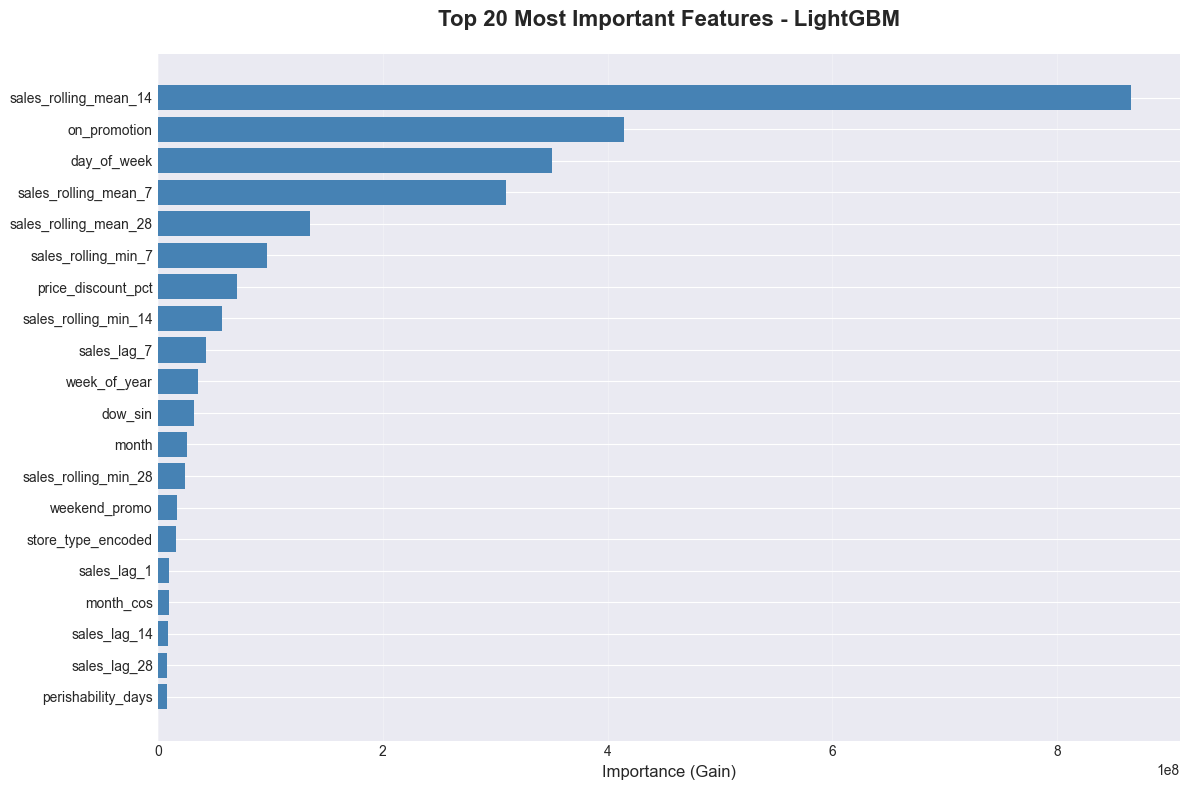


💡 Key Insights:
   • Most important feature: sales_rolling_mean_14
   • Top 5 features contribute: 80.4% of total importance


In [6]:
# Cell 6: Feature Importance
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Display top 20 features
print("\n🏆 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title('Top 20 Most Important Features - LightGBM', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print(f"   • Most important feature: {feature_importance.iloc[0]['feature']}")
print(f"   • Top 5 features contribute: {feature_importance.head(5)['importance'].sum() / feature_importance['importance'].sum() * 100:.1f}% of total importance")

In [7]:
# Cell 7: XGBoost Model
print("🚀 XGBOOST MODEL")
print("=" * 70)

# Define parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'tree_method': 'hist'
}

print("📋 Training XGBoost model...")

# Train model
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=100
)

print(f"\n✅ Training completed!")
print(f"   • Best iteration: {xgb_model.best_iteration}")

# Predictions
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
print("\n📊 TEST SET Performance:")
xgb_test_metrics = calculate_metrics(y_test, xgb_test_pred, "XGBoost (Test)")

# Store results
results.append({
    'Model': 'XGBoost',
    'MAE': xgb_test_metrics['MAE'],
    'RMSE': xgb_test_metrics['RMSE'],
    'MAPE': xgb_test_metrics['MAPE'],
    'R2': xgb_test_metrics['R2']
})

print("\n✅ XGBoost model trained successfully!")

🚀 XGBOOST MODEL
📋 Training XGBoost model...
[0]	validation_0-rmse:119.76287	validation_1-rmse:140.82652
[100]	validation_0-rmse:17.30945	validation_1-rmse:22.50769
[176]	validation_0-rmse:16.51110	validation_1-rmse:22.47744

✅ Training completed!
   • Best iteration: 126

📊 TEST SET Performance:

XGBoost (Test) Performance:
   • MAE:  17.01
   • RMSE: 22.38
   • MAPE: 13.20%
   • R²:   0.8667

✅ XGBoost model trained successfully!


📊 MODEL COMPARISON

🏆 Model Performance Comparison:
           Model       MAE      RMSE      MAPE       R2
        LightGBM 16.753920 21.880026 13.069203 0.872517
         XGBoost 17.013629 22.377378 13.198802 0.866656
Baseline (Lag 7) 32.747234 47.177573 24.391135 0.407312


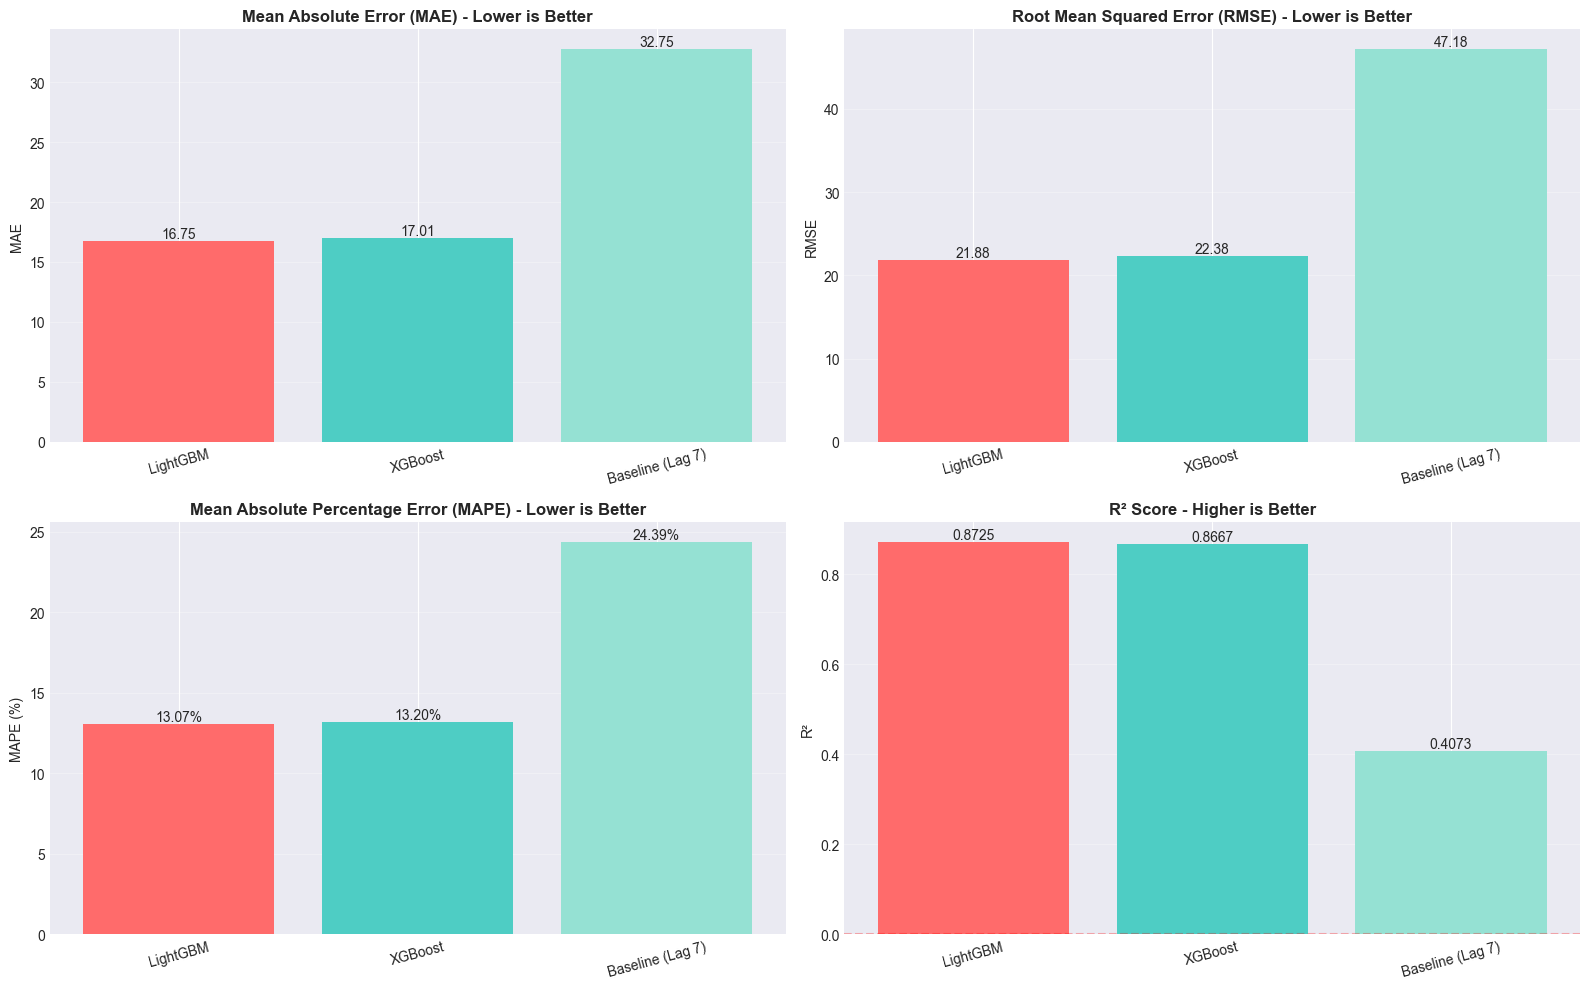


🎯 BEST MODEL: LightGBM
   • MAE: 16.75
   • RMSE: 21.88
   • MAPE: 13.07%
   • R²: 0.8725

📈 IMPROVEMENT OVER BASELINE:
   • MAE improved by: 48.84%
   • RMSE improved by: 53.62%


In [8]:
# Cell 8: Compare All Models
print("📊 MODEL COMPARISON")
print("=" * 70)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n🏆 Model Performance Comparison:")
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MAE comparison
axes[0, 0].bar(results_df['Model'], results_df['MAE'], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0, 0].set_title('Mean Absolute Error (MAE) - Lower is Better', fontweight='bold')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['MAE']):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# RMSE comparison
axes[0, 1].bar(results_df['Model'], results_df['RMSE'], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0, 1].set_title('Root Mean Squared Error (RMSE) - Lower is Better', fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['RMSE']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# MAPE comparison
axes[1, 0].bar(results_df['Model'], results_df['MAPE'], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1, 0].set_title('Mean Absolute Percentage Error (MAPE) - Lower is Better', fontweight='bold')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['MAPE']):
    axes[1, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# R² comparison
axes[1, 1].bar(results_df['Model'], results_df['R2'], color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1, 1].set_title('R² Score - Higher is Better', fontweight='bold')
axes[1, 1].set_ylabel('R²')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.3)
for i, v in enumerate(results_df['R2']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate improvement over baseline
best_model = results_df.iloc[0]
baseline_model = results_df[results_df['Model'].str.contains('Baseline')].iloc[0]

improvement_mae = ((baseline_model['MAE'] - best_model['MAE']) / baseline_model['MAE']) * 100
improvement_rmse = ((baseline_model['RMSE'] - best_model['RMSE']) / baseline_model['RMSE']) * 100

print(f"\n🎯 BEST MODEL: {best_model['Model']}")
print(f"   • MAE: {best_model['MAE']:.2f}")
print(f"   • RMSE: {best_model['RMSE']:.2f}")
print(f"   • MAPE: {best_model['MAPE']:.2f}%")
print(f"   • R²: {best_model['R2']:.4f}")

print(f"\n📈 IMPROVEMENT OVER BASELINE:")
print(f"   • MAE improved by: {improvement_mae:.2f}%")
print(f"   • RMSE improved by: {improvement_rmse:.2f}%")

🔍 PREDICTION ANALYSIS


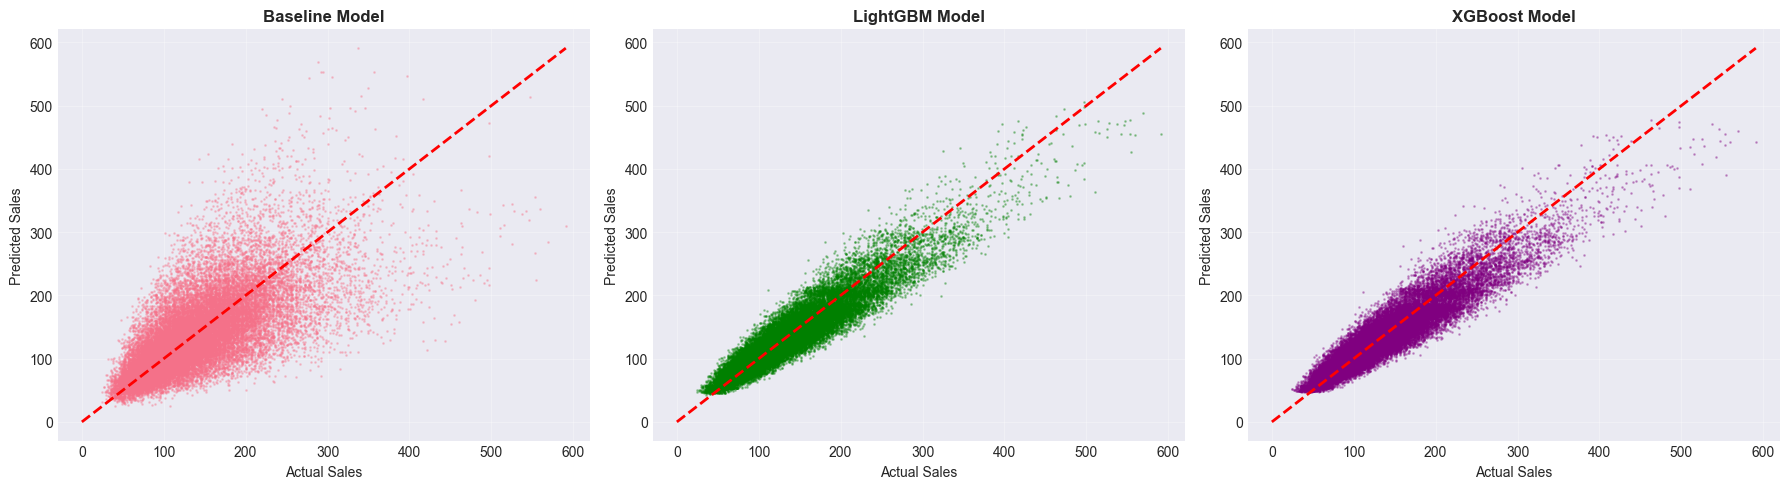


📊 Residual Analysis (LightGBM):
   • Mean residual: 1.75
   • Std residual: 21.81
   • Max overestimation: -103.15
   • Max underestimation: 146.81


In [9]:
# Cell 9: Analyze Predictions
print("🔍 PREDICTION ANALYSIS")
print("=" * 70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'actual': y_test.values,
    'baseline': baseline_test,
    'lightgbm': lgb_test_pred,
    'xgboost': xgb_test_pred
})

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline
axes[0].scatter(comparison_df['actual'], comparison_df['baseline'], alpha=0.3, s=1)
axes[0].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Baseline Model', fontweight='bold')
axes[0].grid(alpha=0.3)

# LightGBM
axes[1].scatter(comparison_df['actual'], comparison_df['lightgbm'], alpha=0.3, s=1, color='green')
axes[1].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sales')
axes[1].set_ylabel('Predicted Sales')
axes[1].set_title('LightGBM Model', fontweight='bold')
axes[1].grid(alpha=0.3)

# XGBoost
axes[2].scatter(comparison_df['actual'], comparison_df['xgboost'], alpha=0.3, s=1, color='purple')
axes[2].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Sales')
axes[2].set_ylabel('Predicted Sales')
axes[2].set_title('XGBoost Model', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual analysis
print("\n📊 Residual Analysis (LightGBM):")
lgb_residuals = y_test.values - lgb_test_pred
print(f"   • Mean residual: {np.mean(lgb_residuals):.2f}")
print(f"   • Std residual: {np.std(lgb_residuals):.2f}")
print(f"   • Max overestimation: {np.min(lgb_residuals):.2f}")
print(f"   • Max underestimation: {np.max(lgb_residuals):.2f}")

🔍 PREDICTION ANALYSIS


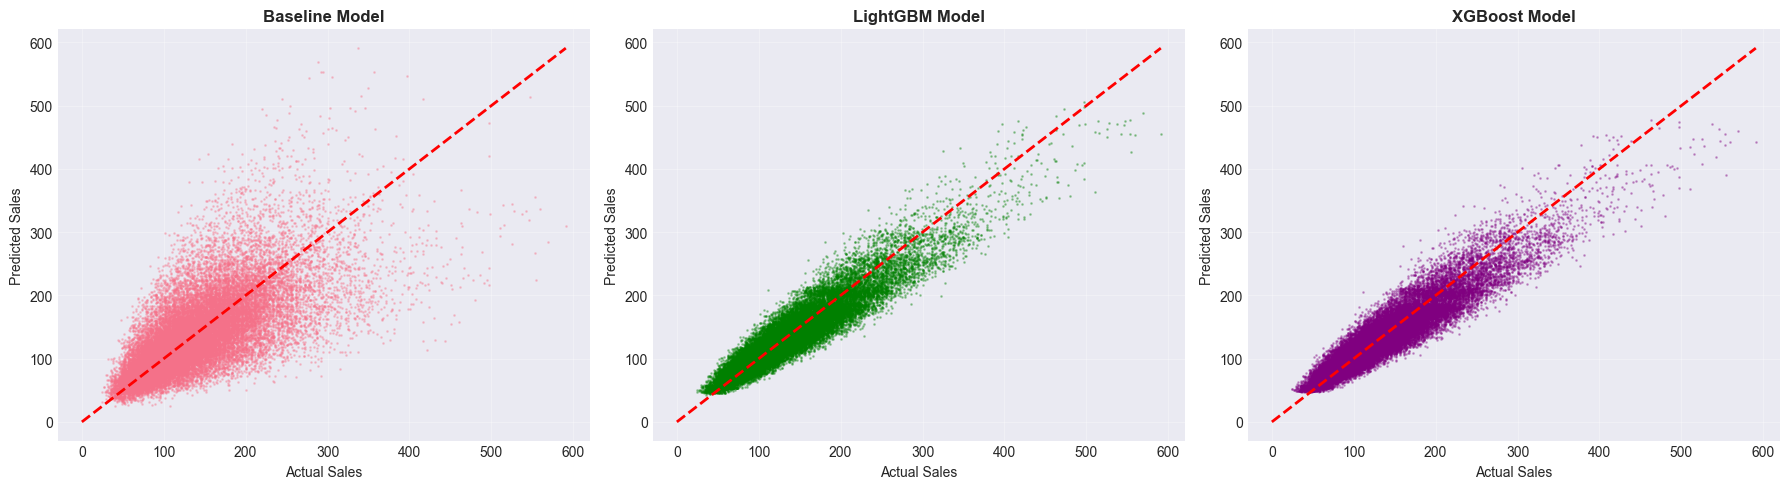


📊 Residual Analysis (LightGBM):
   • Mean residual: 1.75
   • Std residual: 21.81
   • Max overestimation: -103.15
   • Max underestimation: 146.81


In [10]:
# Cell 9: Analyze Predictions
print("🔍 PREDICTION ANALYSIS")
print("=" * 70)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'actual': y_test.values,
    'baseline': baseline_test,
    'lightgbm': lgb_test_pred,
    'xgboost': xgb_test_pred
})

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline
axes[0].scatter(comparison_df['actual'], comparison_df['baseline'], alpha=0.3, s=1)
axes[0].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Baseline Model', fontweight='bold')
axes[0].grid(alpha=0.3)

# LightGBM
axes[1].scatter(comparison_df['actual'], comparison_df['lightgbm'], alpha=0.3, s=1, color='green')
axes[1].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sales')
axes[1].set_ylabel('Predicted Sales')
axes[1].set_title('LightGBM Model', fontweight='bold')
axes[1].grid(alpha=0.3)

# XGBoost
axes[2].scatter(comparison_df['actual'], comparison_df['xgboost'], alpha=0.3, s=1, color='purple')
axes[2].plot([0, comparison_df['actual'].max()], [0, comparison_df['actual'].max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Sales')
axes[2].set_ylabel('Predicted Sales')
axes[2].set_title('XGBoost Model', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual analysis
print("\n📊 Residual Analysis (LightGBM):")
lgb_residuals = y_test.values - lgb_test_pred
print(f"   • Mean residual: {np.mean(lgb_residuals):.2f}")
print(f"   • Std residual: {np.std(lgb_residuals):.2f}")
print(f"   • Max overestimation: {np.min(lgb_residuals):.2f}")
print(f"   • Max underestimation: {np.max(lgb_residuals):.2f}")

In [11]:
# Cell 10: Save Trained Models
import pickle
import os

os.makedirs('../models', exist_ok=True)

# Save LightGBM model
lgb_model.save_model('../models/lightgbm_model.txt')
print("✅ LightGBM model saved: models/lightgbm_model.txt")

# Save XGBoost model
with open('../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("✅ XGBoost model saved: models/xgboost_model.pkl")

# Save feature names
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("✅ Feature names saved: models/feature_names.pkl")

# Save results
results_df.to_csv('../models/model_comparison.csv', index=False)
print("✅ Model comparison saved: models/model_comparison.csv")

print("\n" + "=" * 70)
print("🎉 MODEL TRAINING COMPLETE!")
print("=" * 70)
print(f"✅ Best Model: {best_model['Model']}")
print(f"✅ Test RMSE: {best_model['RMSE']:.2f}")
print(f"✅ Test MAPE: {best_model['MAPE']:.2f}%")
print(f"✅ Improvement over baseline: {improvement_rmse:.2f}%")
print("\n📁 All models saved to: models/")
print("=" * 70)

✅ LightGBM model saved: models/lightgbm_model.txt
✅ XGBoost model saved: models/xgboost_model.pkl
✅ Feature names saved: models/feature_names.pkl
✅ Model comparison saved: models/model_comparison.csv

🎉 MODEL TRAINING COMPLETE!
✅ Best Model: LightGBM
✅ Test RMSE: 21.88
✅ Test MAPE: 13.07%
✅ Improvement over baseline: 53.62%

📁 All models saved to: models/
